### aim: 

### date: 

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [5]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## definitions of equations for individual factors

In [6]:
def effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area):
    
    dfco2 = mn_kg*0.04*mn_pCO2*sst_delta #dfCO2 = kg(4%-pCO2/degree x dSST)
    dfco2_pgCyr_SST = dfco2 * PgC_mol * SO_area #dfCO2 in PgC/yr

    return dfco2_pgCyr_SST

def effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area,\
                grad_dFedz, dmudFe, mu_L, diatconc, efratio):
    #dic
    dDIC = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_MLD_DIC = dfCO2_DIC * PgC_mol * SO_area 

    ##ta
    dfcCO2_TA = (-1/3)*dfCO2_DIC
    dfco2_pgCyr_MLD_TA = dfcCO2_TA * PgC_mol * SO_area 

    #iron (ecosystem)
    dFe = mld_delta *  grad_dFedz #dFe = dMLD x dFe/dz 
    #print(dFe)
    dDIC_fe = -1 * dmudFe * dFe * mu_L * diatconc * 365.25 * efratio#dDIC = -dmu/dFe x dFe x mu_L x DIA x dtime  
    dpCO2_Fe = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_fe  #dpCO2 = R x pCO2/DIC x dDIC
    #print(dpCO2_Fe)
    dfCO2_Fe = mn_kg * dpCO2_Fe
    #print(dfCO2_Fe)
    dfco2_pgCyr_MLD_Fe = dfCO2_Fe * PgC_mol * SO_area
    #print(dfco2_pgCyr_MLD_Fe)

    return dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe

# def effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio):

#     dfco2_pgCyr_OT_DIC = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001*0.000000000000012 #dfCO2_DIC = dOverturning x (dDICv)
#     dfco2_pgCyr_OT_TA = -(1/3)*dfco2_pgCyr_OT_DIC #dfCO2_TA = -1/3 x dfCO2_DIC
#     #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
#     dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
#     dfco2_pgCyr_OT_Fe = dDICv * ot_delta * 1e6 * 1000*31560000*0.000001*0.000000000000012 # dfCO2_DIC = dOverturning x (dDIC)

#     return dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe

def effect_OT_withRfact(ot_delta,grad_DIC_surfdeep, SO_area, mn_Revfact, mn_pCO2, PgC_mol, mn_DIC, mn_kg,\
                       dmudFe, grad_dFev, mu_L, diatconc, efratio, verbose = False):

    dDIC_mol_yr = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001  #L/m3 * mol/umol * sec/yr
    dDIC_mol_per_m2 = dDIC_mol_yr/SO_area
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_mol_per_m2 #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_OT_DIC = dfCO2_DIC * PgC_mol * SO_area 
    
    dfco2_pgCyr_OT_TA = (-1/3) * dfco2_pgCyr_OT_DIC
    
    dDIC_Fe = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio
    dfco2_pgCyr_OT_DIC2 = dDIC_Fe * ot_delta * 1e6 * 1000*31560000*0.000001*0.000000000000012
    
    dpCO2_Fe = mn_Revfact * mn_pCO2 / mn_DIC * dfco2_pgCyr_OT_DIC2  #dpCO2 = R x pCO2/DIC x dDIC
    #print(dpCO2_Fe)
    dfCO2_Fe = mn_kg * dpCO2_Fe
    #print(dfCO2_Fe)
    dfco2_pgCyr_OT_Fe = dfCO2_Fe * PgC_mol * SO_area    
    
    #dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    if verbose:
        print('*******')
        print(f'ot delta {ot_delta}')
        print(f'DIC ef pgC/yr: {dfco2_pgCyr_OT_DIC} TA ef pgC/yr {dfco2_pgCyr_OT_TA}')
        print(f'ecosystem pgC/yr: {dfco2_pgCyr_OT_Fe}')
        print('*******')
    
    return dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe



def give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                    mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = False): 

    dfco2_pgCyr_SST  = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)

    dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = \
        effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area, grad_dFedz, dmudFe, mu_L, diatconc, efratio)

#     dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe = \
#         effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio)
    
    dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe = \
    effect_OT_withRfact(ot_delta,grad_DIC_surfdeep, SO_area, mn_Revfact, mn_pCO2, PgC_mol, mn_DIC, mn_kg,\
    dmudFe, grad_dFev, mu_L, diatconc, efratio, verbose = True)
    
    CO2_SST = dfco2_pgCyr_SST
    CO2_MLD_phys_chem = dfco2_pgCyr_MLD_TA + dfco2_pgCyr_MLD_DIC
    CO2_OT_phys_chem = dfco2_pgCyr_OT_TA + dfco2_pgCyr_OT_DIC
    CO2_OT_MLD_bio = dfco2_pgCyr_OT_Fe + dfco2_pgCyr_MLD_Fe
    CO2_tot = CO2_SST + CO2_MLD_phys_chem + CO2_OT_phys_chem + CO2_OT_MLD_bio
    if verbose:
        
        print('individual effects')
        print(f'effect SST pgC/yr {dfco2_pgCyr_SST}')
        print(f'effect MLD (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_MLD_TA}, {dfco2_pgCyr_MLD_DIC}, {dfco2_pgCyr_MLD_Fe}')
        print(f'effect OT (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_OT_TA}, {dfco2_pgCyr_OT_DIC}, {dfco2_pgCyr_OT_Fe}')

        print('')
        print('--summary (in PgC/yr)')
        print(f'Change in CO2 flux due to SST change {CO2_SST}')
        print(f'Change in CO2 flux due to MLD change (combined physico-chemical effects) {CO2_MLD_phys_chem}')
        print(f'Change in CO2 flux due to Overturning change (combined physico-chemical effects) {CO2_OT_phys_chem}')
        print(f'Change in CO2 flux due to MLD+Overturning change (ecosystem effects) {CO2_OT_MLD_bio}')
        print(f'Total change in CO2 flux {CO2_tot}')

    return CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem, dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot

#         dfco2_pgCyr_SST = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)
#         dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area)



def make_BOE_output(changes_str, input_str, output_str, verbose = False):
    
    changes = xr.open_dataset(changes_str)
    inputs = xr.open_dataset(input_str)
    savenam = output_str
    print(f'making {savenam}')
    
    datar = np.zeros([3,5,6,2,2])
    sigar = np.zeros([3,5,6,2,2])
    data_vars = {'trend':(['period', 'season', 'quantity', 'forcing','scenario'], datar,
    {'units': '/yr',
    'long_name':''}),
                 'sig':(['period', 'season', 'quantity', 'forcing','scenario'], sigar,
    {'units': '/yr',
    'long_name':''}),
    }
    # define coordinates
    coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
              'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
              'quantity': (['quantity'], ['CO2_SST','CO2_MLD_phys_chem',\
                                          'CO2_OT_phys_chem','CO2_MLD_bio',\
                                          'CO2_OT_bio','CO2_tot']),
              'forcing': (['forcing'], ['ghg','ozone']),
              'scenario': (['scenario'], ['ssp1','ssp3']),

             }
    attrs = {'made in':'scratch/BOE-SOcarbon/sketch-refactor.ipynb',
    'desc': 'yearly medusa files, saving only variables of interest'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)

    ###constants
    efratio = 0.5
    PgC_mol = 1.2e-14 # pgC/mol
    SO_area = 5.94e13 # assuming 1/6 of the global ocean south of 50S, calculate this from mesh mask

    periodar =  ['1950-2000','2000-2050','2050-2100']
    seasonar = ['FY','DJF','MAM','JJA','SON']
    forcingar = ['ghg','ozone']
    scenarioar = ['ssp1','ssp3']

    for p in periodar:
        tpe = int(p[0:4])
        for s in seasonar:
            for f in forcingar:
                for sc in scenarioar:

                    sst_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'sst', \
                      'forcing': f, 'scenario': sc }].values *5 # / decade to / 50 yrs  
                    mld_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'mld', \
                      'forcing': f, 'scenario': sc }].values*5  # / decade to / 50 yrs  
                    ot_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'ot', \
                      'forcing': f, 'scenario': sc }].values *5 # / decade to / 50 yrs  

                    sst_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'sst', \
                      'forcing': f, 'scenario': sc }].values # / decade to / 50 yrs  
                    mld_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'mld', \
                      'forcing': f, 'scenario': sc }].values  # / decade to / 50 yrs  
                    ot_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'ot', \
                      'forcing': f, 'scenario': sc }].values  # / decade to / 50 yrs  


                    if verbose:
                        print(f'{p} (starts {tpe}), {s}, {f}, {sc}')
                        print(f'---temp delta {sst_t}, mld delta {mld_t}, ot delta {ot_t}')
                        print(f'---temp sig {sst_sig}, mld sig {mld_sig}, ot sig {ot_sig}')

                    mn_kg = inputs.mn_kg.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_pCO2 = inputs.mn_pCO2.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dDICdz = inputs.grad_dDICdz.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_Revfact = inputs.mn_Revfact.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_DIC_surfdeep = inputs.grad_DIC_surfdeep.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    diatconc = inputs.diatconc.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dFedz = inputs.grad_dFedz.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dFev = inputs.grad_dFev.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    dmudFe = inputs.dmudFe.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_DIC = inputs.mn_DIC.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mu_L = inputs.mu_L.loc[{'period':p, 'season':s, 'scenario': sc }].values 


                    CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem,\
                    dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot =\
                    give_me_summary(mn_kg,mn_pCO2,sst_t,PgC_mol,SO_area,\
                    mld_t, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_t,grad_DIC_surfdeep, grad_dFev, efratio, verbose = verbose)


                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }] = CO2_SST
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] = CO2_OT_phys_chem
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] = CO2_MLD_phys_chem
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] = dfco2_pgCyr_MLD_Fe
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }] = dfco2_pgCyr_OT_Fe
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] = CO2_tot

                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }] = sst_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] = ot_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] = mld_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] = mld_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }] = ot_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] = np.min([sst_sig,ot_sig,mld_sig])


            if verbose:
                print()
                print()

    ds.to_netcdf(savenam)
    print('done calculations')
    
    return ds


## calculate summary for a netcdf of changes and parameter inputs

In [7]:

# verbose = True
# changes_str = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc'
# input_str = './data/BOE-INPUT-medusamodel.nc'
# output_str = './data/BOE-OUTPUT-medusamodel3.nc'
# pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)



# verbose = True
# changes_str = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc'
# input_str = './data/BOE-INPUT-medusamodel.nc'
# output_str = './data/BOE-OUTPUT-medusamodel3.nc'
# pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)


input_str = './data/BOE-INPUT-bio-MEDUSA-fer-MEDUSA-cchem-MEDUSA.nc'
verbose = True
changes_str = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc'
#input_str = './data/BOE-INPUT-medusamodel.nc'
output_str = './data/BOE-OUTPUT-bio-MEDUSA-fer-MEDUSA-cchem-MEDUSA.nc'
pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)


input_str = './data/BOE-INPUT-bio-MEDUSA-fer-GEOTRACES-cchem-MEDUSA.nc'
verbose = True
changes_str = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc'
#input_str = './data/BOE-INPUT-medusamodel.nc'
output_str = './data/BOE-OUTPUT-bio-MEDUSA-fer-GEOTRACES-cchem-MEDUSA.nc'
pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)


making ./data/BOE-OUTPUT-bio-MEDUSA-fer-MEDUSA-cchem-MEDUSA.nc
1950-2000 (starts 1950), FY, ghg, ssp1
---temp delta 0.03761499504220941, mld delta -3.201252840678581, ot delta -1.4252295483617514
---temp sig 0.0, mld sig 1.0, ot sig 0.0
*******
ot delta -1.4252295483617514
DIC ef pgC/yr: -0.006648995426783246 TA ef pgC/yr 0.0022163318089277488
ecosystem pgC/yr: 3.986551960579434e-05
*******
individual effects
effect SST pgC/yr 0.02194154377765384
effect MLD (TA, DIC, Fe) pgC/yr 0.021834891778745428, -0.06550467533623629, 0.002295173121161734
effect OT (TA, DIC, Fe) pgC/yr 0.0022163318089277488, -0.006648995426783246, 3.986551960579434e-05

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.02194154377765384
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.04366978355749086
Change in CO2 flux due to Overturning change (combined physico-chemical effects) -0.0044326636178554975
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.0023

*******
ot delta -1.3104651922426807
DIC ef pgC/yr: -0.005562137738446611 TA ef pgC/yr 0.001854045912815537
ecosystem pgC/yr: 3.5255262674618977e-06
*******
individual effects
effect SST pgC/yr -0.010189993882974245
effect MLD (TA, DIC, Fe) pgC/yr 0.018207943143501007, -0.05462382943050302, 0.00036227780912365164
effect OT (TA, DIC, Fe) pgC/yr 0.001854045912815537, -0.005562137738446611, 3.5255262674618977e-06

--summary (in PgC/yr)
Change in CO2 flux due to SST change -0.010189993882974245
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.036415886287002014
Change in CO2 flux due to Overturning change (combined physico-chemical effects) -0.003708091825631074
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.00036580333539111353
Total change in CO2 flux -0.049948168660216216
1950-2000 (starts 1950), JJA, ghg, ssp3
---temp delta -0.017259231450822723, mld delta -3.406606843825733, ot delta -1.3104651922426807
---temp sig 0.0, mld sig 0.0, o

2000-2050 (starts 2000), DJF, ozone, ssp1
---temp delta 0.538887176737262, mld delta -4.975781049837125, ot delta 0.002956661991213122
---temp sig 1.0, mld sig 1.0, ot sig 0.0
*******
ot delta 0.002956661991213122
DIC ef pgC/yr: 1.5318608822748155e-05 TA ef pgC/yr -5.106202940916051e-06
ecosystem pgC/yr: -4.3973964160732306e-07
*******
individual effects
effect SST pgC/yr 0.3838249470262481
effect MLD (TA, DIC, Fe) pgC/yr 0.04759942471961359, -0.14279827415884078, 0.014591142705745066
effect OT (TA, DIC, Fe) pgC/yr -5.106202940916051e-06, 1.5318608822748155e-05, -4.3973964160732306e-07

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.3838249470262481
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.09519884943922718
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 1.0212405881832104e-05
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.014590702966103458
Total change in CO2 flux 0.3032270129590

*******
ot delta -1.6087232890081682
DIC ef pgC/yr: -0.005806526118961429 TA ef pgC/yr 0.0019355087063204761
ecosystem pgC/yr: 1.8948307687525397e-05
*******
individual effects
effect SST pgC/yr 0.21269884242357612
effect MLD (TA, DIC, Fe) pgC/yr 0.011734982656222892, -0.03520494796866867, 0.0012799006007859159
effect OT (TA, DIC, Fe) pgC/yr 0.0019355087063204761, -0.005806526118961429, 1.8948307687525397e-05

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.21269884242357612
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.02346996531244578
Change in CO2 flux due to Overturning change (combined physico-chemical effects) -0.0038710174126409527
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.0012988489084734412
Total change in CO2 flux 0.18665670860696285


2050-2100 (starts 2050), FY, ghg, ssp1
---temp delta 0.08791858358111422, mld delta 2.071266452022858, ot delta -0.3579225847923118
---temp sig 0.0, mld sig 0.0, ot sig 0.

2050-2100 (starts 2050), JJA, ghg, ssp3
---temp delta 1.4543146092781378, mld delta -4.188105012815272, ot delta 0.28151143758493824
---temp sig 1.0, mld sig 1.0, ot sig 0.0
*******
ot delta 0.28151143758493824
DIC ef pgC/yr: 0.0005571487620243561 TA ef pgC/yr -0.00018571625400811868
ecosystem pgC/yr: -1.4730325790445068e-06
*******
individual effects
effect SST pgC/yr 1.7355372928297574
effect MLD (TA, DIC, Fe) pgC/yr 0.01996850293458138, -0.05990550880374414, 0.0016296442446816148
effect OT (TA, DIC, Fe) pgC/yr -0.00018571625400811868, 0.0005571487620243561, -1.4730325790445068e-06

--summary (in PgC/yr)
Change in CO2 flux due to SST change 1.7355372928297574
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.03993700586916275
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.0003714325080162374
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.0016281712121025702
Total change in CO2 flux 1.697599890680713

1950-2000 (starts 1950), DJF, ghg, ssp1
---temp delta 0.14435792289229354, mld delta -3.814429369956662, ot delta -2.245489794974077
---temp sig 0.0, mld sig 1.0, ot sig 1.0
*******
ot delta -2.245489794974077
DIC ef pgC/yr: -0.011982192059354486 TA ef pgC/yr 0.003994064019784829
ecosystem pgC/yr: 0.0006024856692706198
*******
individual effects
effect SST pgC/yr 0.08254178965492727
effect MLD (TA, DIC, Fe) pgC/yr 0.03507654832098183, -0.1052296449629455, 0.0062987813144041414
effect OT (TA, DIC, Fe) pgC/yr 0.003994064019784829, -0.011982192059354486, 0.0006024856692706198

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.08254178965492727
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.07015309664196367
Change in CO2 flux due to Overturning change (combined physico-chemical effects) -0.007988128039569657
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.006901266983674761
Total change in CO2 flux 0.011301831957068699
1950-20

*******
ot delta 0.3319657232835816
DIC ef pgC/yr: 0.001341561475961828 TA ef pgC/yr -0.0004471871586539426
ecosystem pgC/yr: -2.5744419746444755e-05
*******
individual effects
effect SST pgC/yr -0.01288522073710475
effect MLD (TA, DIC, Fe) pgC/yr 0.011710664813410722, -0.03513199444023217, 0.0012965436098074303
effect OT (TA, DIC, Fe) pgC/yr -0.0004471871586539426, 0.001341561475961828, -2.5744419746444755e-05

--summary (in PgC/yr)
Change in CO2 flux due to SST change -0.01288522073710475
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.023421329626821447
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.0008943743173078853
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.0012707991900609856
Total change in CO2 flux -0.034141376856557326
1950-2000 (starts 1950), SON, ozone, ssp1
---temp delta -0.059136245433780765, mld delta 13.390636714128284, ot delta 3.736252902134523
---temp sig 0.0, mld sig 1.0, ot

2000-2050 (starts 2000), MAM, ozone, ssp3
---temp delta 0.3505117903549211, mld delta -4.441840080362402, ot delta -1.9375328049897433
---temp sig 1.0, mld sig 0.0, ot sig 0.0
*******
ot delta -1.9375328049897433
DIC ef pgC/yr: -0.009155228973671213 TA ef pgC/yr 0.0030517429912237373
ecosystem pgC/yr: 0.0002191052885258686
*******
individual effects
effect SST pgC/yr 0.2631104697142044
effect MLD (TA, DIC, Fe) pgC/yr 0.037556792098421304, -0.11267037629526393, 0.0030914201376223546
effect OT (TA, DIC, Fe) pgC/yr 0.0030517429912237373, -0.009155228973671213, 0.0002191052885258686

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.2631104697142044
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.07511358419684262
Change in CO2 flux due to Overturning change (combined physico-chemical effects) -0.0061034859824474754
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.0033105254261482234
Total change in CO2 flux 0.18520392496106253



*******
ot delta 1.2468672661502147
DIC ef pgC/yr: 0.00736291481262417 TA ef pgC/yr -0.00245430493754139
ecosystem pgC/yr: -0.0005169099313427358
*******
individual effects
effect SST pgC/yr 0.03577584861922278
effect MLD (TA, DIC, Fe) pgC/yr -0.01900763841244684, 0.057022915237340537, -0.004029570977744208
effect OT (TA, DIC, Fe) pgC/yr -0.00245430493754139, 0.00736291481262417, -0.0005169099313427358

--summary (in PgC/yr)
Change in CO2 flux due to SST change 0.03577584861922278
Change in CO2 flux due to MLD change (combined physico-chemical effects) 0.038015276824893696
Change in CO2 flux due to Overturning change (combined physico-chemical effects) 0.00490860987508278
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) -0.004546480909086944
Total change in CO2 flux 0.07415325441011231
2050-2100 (starts 2050), DJF, ghg, ssp3
---temp delta 1.7282672557814769, mld delta -1.2665471729456714, ot delta 3.386859145281307
---temp sig 1.0, mld sig 0.0, ot sig 1.0
*******
ot

2050-2100 (starts 2050), SON, ozone, ssp1
---temp delta -0.15343646456130916, mld delta -0.7869164367302903, ot delta -0.16440738990638099
---temp sig 1.0, mld sig 0.0, ot sig 0.0
*******
ot delta -0.16440738990638099
DIC ef pgC/yr: -0.000664064442941 TA ef pgC/yr 0.00022135481431366665
ecosystem pgC/yr: 2.3195844076977144e-05
*******
individual effects
effect SST pgC/yr -0.12417410780126271
effect MLD (TA, DIC, Fe) pgC/yr 0.004060130446474519, -0.012180391339423561, 0.0006832958453390692
effect OT (TA, DIC, Fe) pgC/yr 0.00022135481431366665, -0.000664064442941, 2.3195844076977144e-05

--summary (in PgC/yr)
Change in CO2 flux due to SST change -0.12417410780126271
Change in CO2 flux due to MLD change (combined physico-chemical effects) -0.008120260892949042
Change in CO2 flux due to Overturning change (combined physico-chemical effects) -0.00044270962862733335
Change in CO2 flux due to MLD+Overturning change (ecosystem effects) 0.0007064916894160463
Total change in CO2 flux -0.13203058

### code to make graphs

In [17]:

def make_boe_summary_graph_both_ssps(output_str, fnam_str, valuedesc = ''):
    
    ds = xr.open_dataset(output_str)
    #### ssps 1 and 3 figure
    fact = 1.1
    fig, axs = plt.subplots(5,3, figsize=(15*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    tw = 0.4; lowsigalpha = 0.25; tlw = 1.5; lowsiglw = 0
    
    seasonar = ['FY','FY','FY',\
                'DJF','DJF','DJF',\
                'MAM', 'MAM', 'MAM',\
                'JJA','JJA','JJA',\
                'SON','SON','SON']
    periodar = ['1950-2000','2000-2050','2050-2100']
    for i in range(0,15):

        per = i%3
        p = periodar[per]
        s = seasonar[i]
        fs = ['ghg','ghg','ozone','ozone'];
        scs = ['ssp1','ssp3','ssp1','ssp3']
        inds = [0.45,2.95,5.45,7.95]
        for x in range(4):
            
            f = fs[x]; sc = scs[x]; ind = inds[x]
            
            CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            ##### significances
            CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
            CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
            CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1
            
            CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
            CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
            CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw
            
            
            if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
            if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
            if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha
                
            if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
            if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
            if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
            
            ms = 7
            if ind == inds[0]:
                axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
                           edgecolor = 'k', lw = CO2_tot_lw, label = 'Total $\Delta$ CO2flux')
                
                axs[i].bar(ind+tw*2,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                            edgecolor = 'k', lw = CO2_SST_lw, label = '$\Delta$ CO2flux due to $\Delta$ SST')
                
                axs[i].bar(ind+tw,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                        edgecolor = 'k', lw = CO2_OT_phys_chem_lw, 
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)') 
                
                axs[i].bar(ind+tw*3,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha, \
                        edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
                
                axs[i].bar(ind+tw*4,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                
                axs[i].axvline(x = 5, linestyle = ':', linewidth = tw)

            else:
                axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
                          edgecolor = 'k', lw = CO2_tot_lw)
                
                axs[i].bar(ind+tw*2,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                          edgecolor = 'k', lw = CO2_SST_lw)
                
                axs[i].bar(ind+tw,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_OT_phys_chem_lw, )
                
                axs[i].bar(ind+tw*3,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,)
                
                axs[i].bar(ind+tw*4,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                
                axs[i].axvline(x = 5, linestyle = ':', linewidth = tw)
                axs[i].axvline(x = 5, linestyle = '-', linewidth = 2, color = 'grey')
                axs[i].axvline(x = 2.5, linestyle = ':', linewidth = 0.9, color = 'grey')
                axs[i].axvline(x = 7.5, linestyle = ':', linewidth = 0.9, color = 'grey')

    

        axs[i].set_xticks([1.25,3.75,6.25,8.75])
        axs[i].set_xlim([0,10])
        axs[i].set_xticklabels(['ghg ef. \n ssp1','ghg ef. \n ssp3','ozone \n ef. ssp1','ozone \n ef. ssp3'])
        axs[i].set_title(f'{p} {s}')
        axs[0].set_ylabel('pgC')
        axs[i].axhline(y=0, color = 'k')
        
    axs[2].legend(bbox_to_anchor = [1,1], fontsize = 10)
    plt.suptitle(f'Relative climate-driven contributions to CO2 flux, \n SSP1-2.6 and SSP3-7.0, data source = {valuedesc}')

    plt.tight_layout()
    print(f'saved figure at {fnam_str}')
    plt.savefig(fnam_str)

In [18]:

def make_boe_summary_graph_one_ssp(output_str, fnam_str, tssp, valuedesc = ''):
    
    ds = xr.open_dataset(output_str)
    #### ssps 1 and 3 figure
    fact = 1.1
    fig, axs = plt.subplots(5,3, figsize=(10*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    tw = 0.4; lowsigalpha = 0.25; tlw = 1.5; lowsiglw = 0
    
    seasonar = ['FY','FY','FY',\
                'DJF','DJF','DJF',\
                'MAM', 'MAM', 'MAM',\
                'JJA','JJA','JJA',\
                'SON','SON','SON']
    periodar = ['1950-2000','2000-2050','2050-2100']
    for i in range(0,15):

        per = i%3
        p = periodar[per]
        s = seasonar[i]
        fs = ['ghg','ozone',];
        scs = [tssp,tssp]
        inds = [0.45,2.95,5.45,7.95]
        for x in range(2):
            
            f = fs[x]; sc = scs[x]; ind = inds[x]
            
            CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            ##### significances
            CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
            CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
            CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1
            
            CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
            CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
            CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw
            
            
            if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
            if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
            if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha
                
            if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
            if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
            if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
            
            ms = 7
            if ind == inds[0]:
                axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
                           edgecolor = 'k', lw = CO2_tot_lw, label = 'Total $\Delta$ CO2flux')
                
                axs[i].bar(ind+tw*2,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                            edgecolor = 'k', lw = CO2_SST_lw, label = '$\Delta$ CO2flux due to $\Delta$ SST')
                
                axs[i].bar(ind+tw,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                        edgecolor = 'k', lw = CO2_OT_phys_chem_lw, 
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)') 
                
                axs[i].bar(ind+tw*3,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha, \
                        edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
                
                axs[i].bar(ind+tw*4,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                
                axs[i].axvline(x = 5, linestyle = ':', linewidth = tw)

            else:
                axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
                          edgecolor = 'k', lw = CO2_tot_lw)
                
                axs[i].bar(ind+tw*2,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                          edgecolor = 'k', lw = CO2_SST_lw)
                
                axs[i].bar(ind+tw,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_OT_phys_chem_lw, )
                
                axs[i].bar(ind+tw*3,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,)
                
                axs[i].bar(ind+tw*4,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                
                axs[i].axvline(x = 5, linestyle = ':', linewidth = tw)
                axs[i].axvline(x = 5, linestyle = '-', linewidth = 2, color = 'grey')
                axs[i].axvline(x = 2.5, linestyle = ':', linewidth = 0.9, color = 'grey')
                axs[i].axvline(x = 7.5, linestyle = ':', linewidth = 0.9, color = 'grey')

    

        axs[i].set_xticks([1.25,3.75])
        axs[i].set_xlim([0,5])
        axs[i].set_xticklabels(['ghg \n effect','ozone \n effect'])
        axs[i].set_title(f'{p} {s}')
        axs[0].set_ylabel('pgC')
        axs[i].axhline(y=0, color = 'k')
        
    axs[2].legend(bbox_to_anchor = [1,0.95], fontsize = 10)
    plt.suptitle(f'Relative climate-driven contributions to CO2 flux, \n {tssp}, data source = {valuedesc}')
    plt.tight_layout()
    print(f'saved figure at {fnam_str}')
    plt.savefig(fnam_str)
    



saved figure at ./figs/BOE-FIG-ssp1-CLQdummy.jpg
saved figure at ./figs/BOE-FIG-ssp3-CLQdummy.jpg
saved figure at ./figs/BOE-FIG-bothssp-CLQdummy.jpg
saved figure at ./figs/BOE-FIG-ssp1-medusamodel.jpg
saved figure at ./figs/BOE-FIG-ssp3-medusamodel.jpg
saved figure at ./figs/BOE-FIG-bothssp-medusamodel.jpg


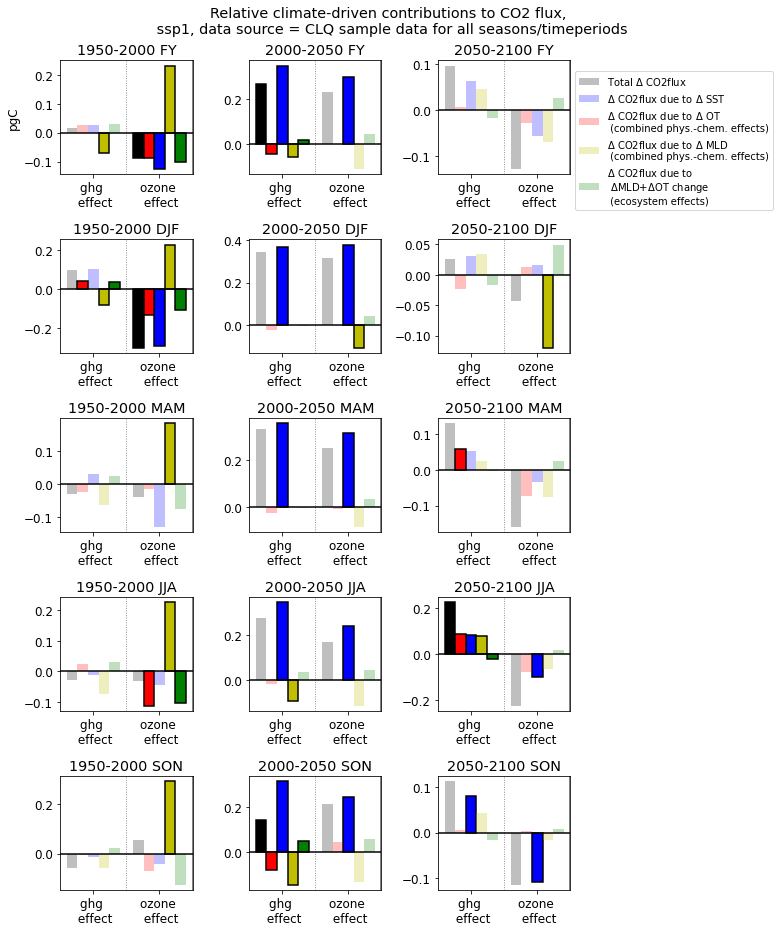

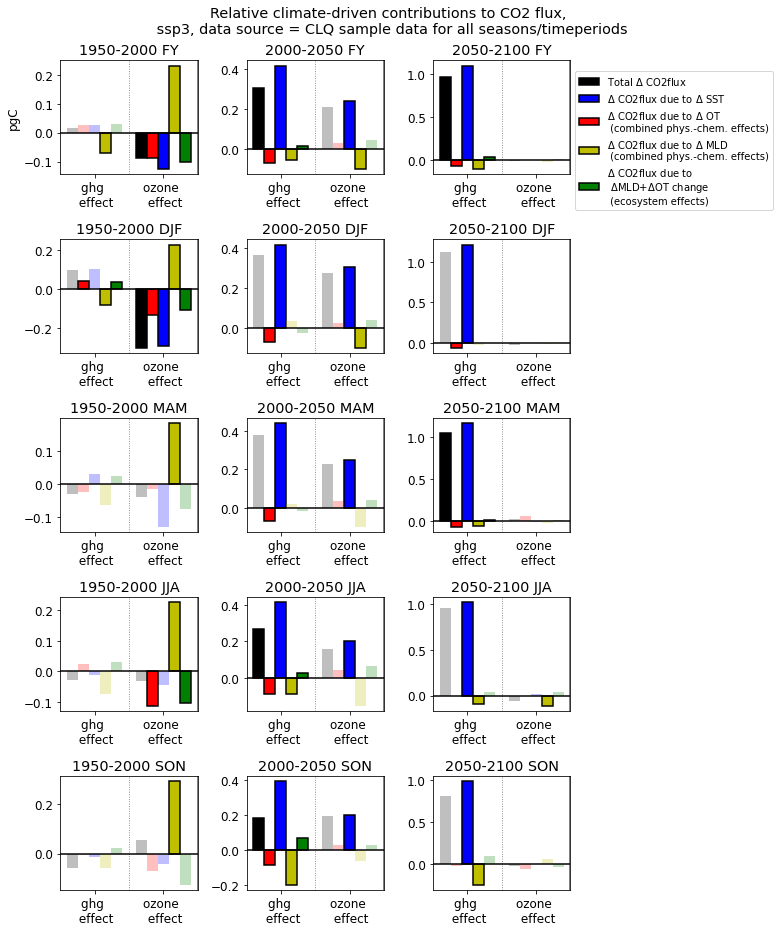

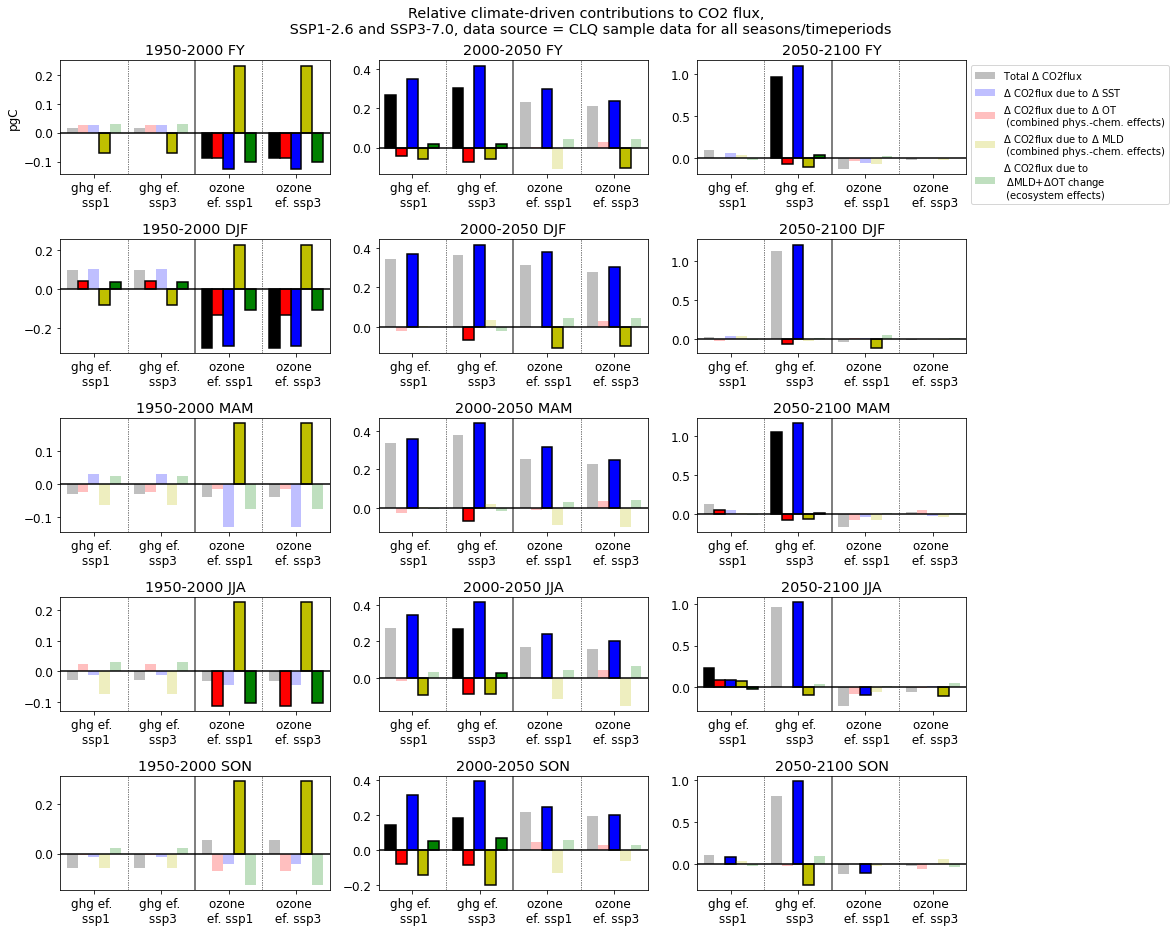

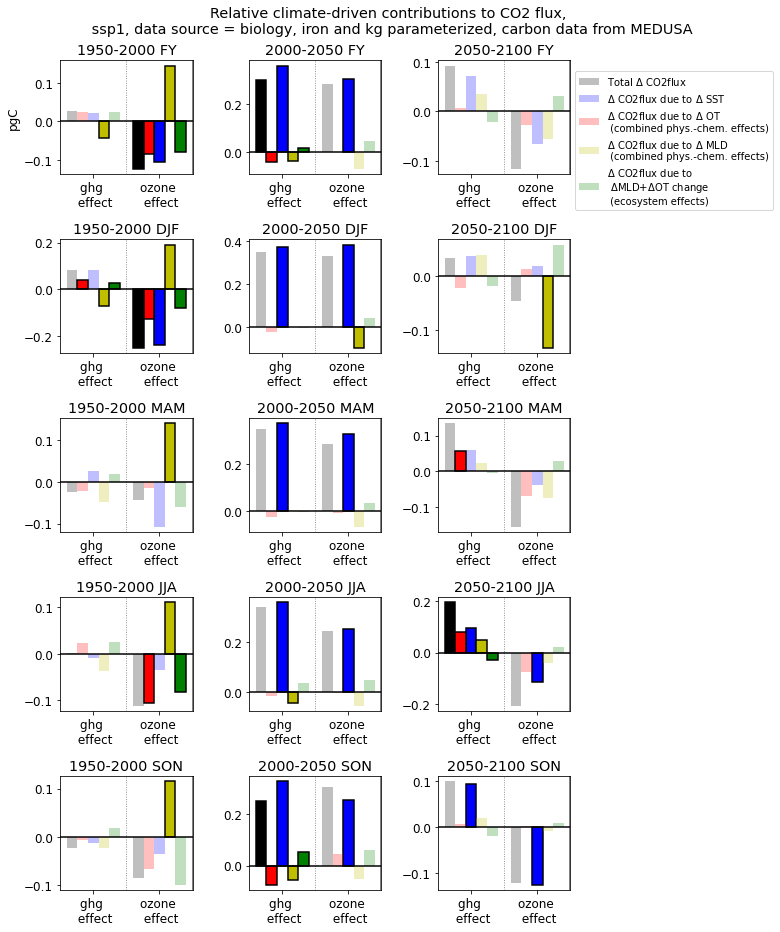

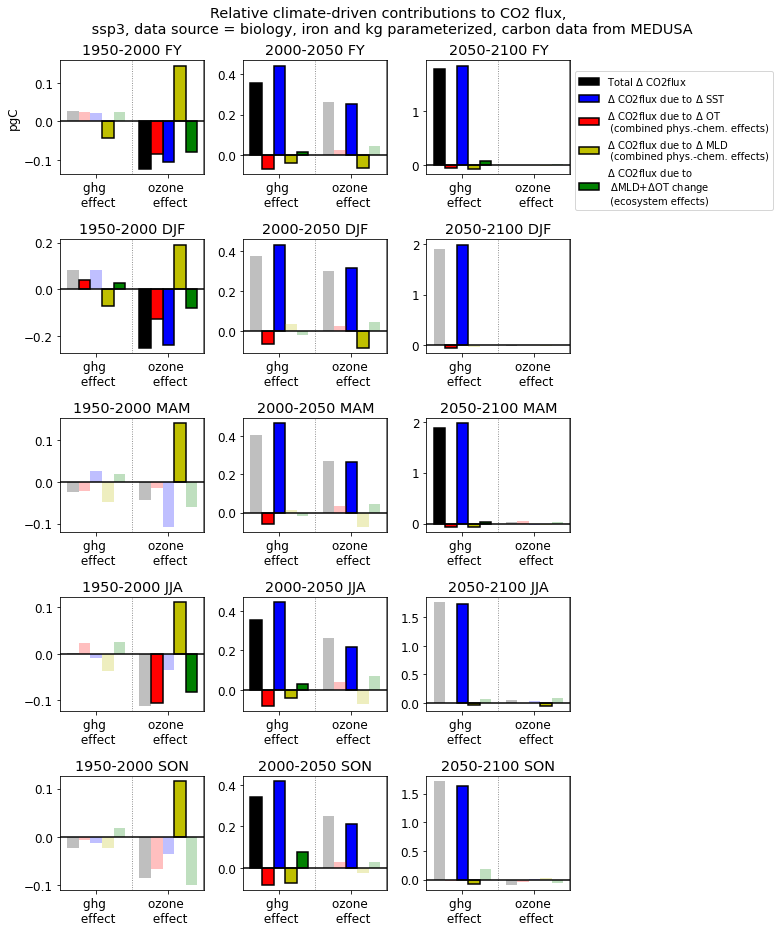

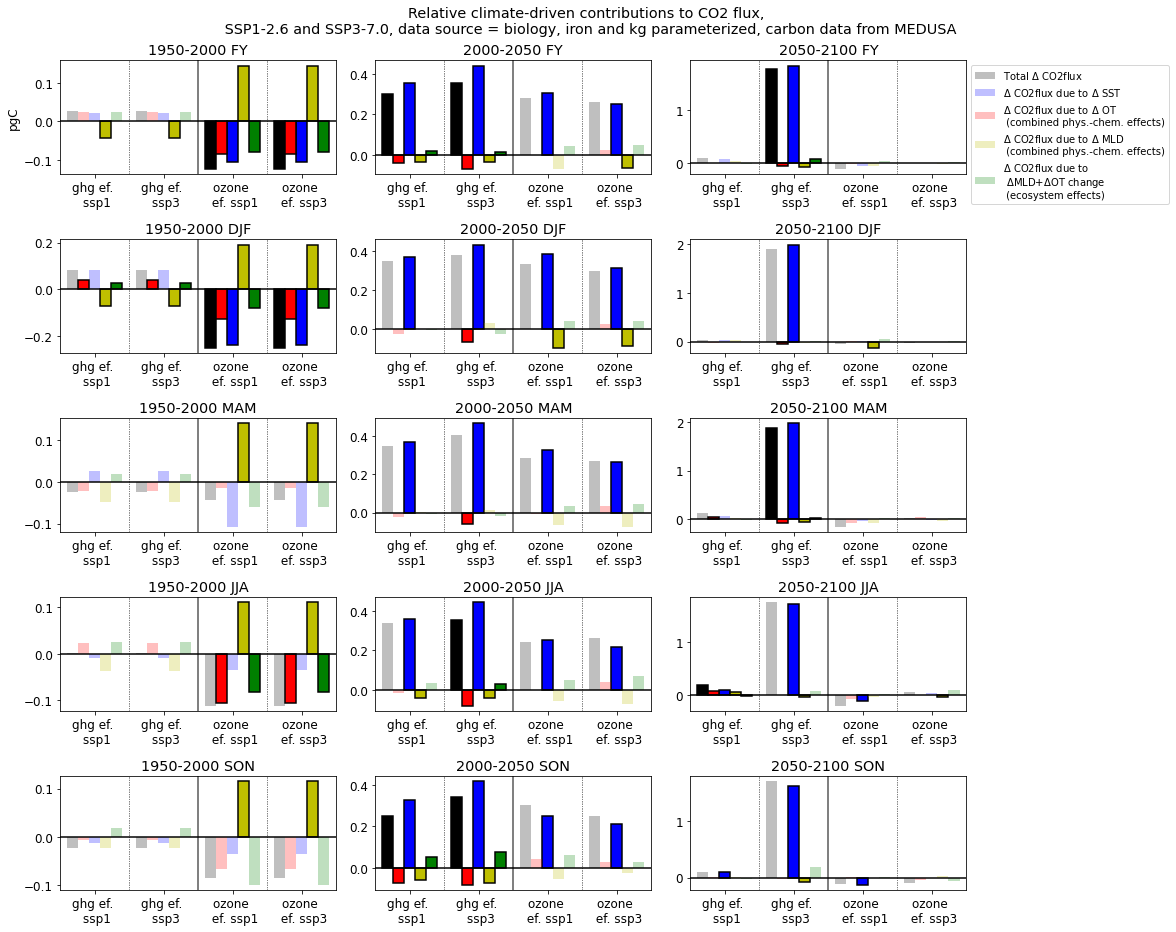

In [20]:
output_str = './data/BOE-OUTPUT-CLQdummy.nc'
valuedesc = 'CLQ sample data for all seasons/timeperiods'

tssp = 'ssp1'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-CLQdummy.jpg'
make_boe_summary_graph_one_ssp(output_str, fnam_str, tssp, valuedesc)

tssp = 'ssp3'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-CLQdummy.jpg'
make_boe_summary_graph_one_ssp(output_str, fnam_str, tssp, valuedesc)

fnam_str = f'./figs/BOE-FIG-bothssp-CLQdummy.jpg'
make_boe_summary_graph_both_ssps(output_str, fnam_str, valuedesc)

######

output_str = './data/BOE-OUTPUT-medusamodel.nc'
valuedesc = 'biology, iron and kg parameterized, carbon data from MEDUSA'

tssp = 'ssp1'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-medusamodel.jpg'
make_boe_summary_graph_one_ssp(output_str, fnam_str, tssp, valuedesc)

tssp = 'ssp3'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-medusamodel.jpg'
make_boe_summary_graph_one_ssp(output_str, fnam_str, tssp, valuedesc)

fnam_str = f'./figs/BOE-FIG-bothssp-medusamodel.jpg'
make_boe_summary_graph_both_ssps(output_str, fnam_str, valuedesc)

In [9]:
plt.rcParams.update({'font.size': 16})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 16}

plt.rc('font', **font)


def make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc = ''):
    
    ds = xr.open_dataset(output_str)
    #### ssps 1 and 3 figure
    fact = 1
    fig, axs = plt.subplots(5,3, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    tw = 0.4; lowsigalpha = 0.25; tlw = 1.5; lowsiglw = 0
    
    seasonar = ['FY','FY','FY',\
                'DJF','DJF','DJF',\
                'MAM', 'MAM', 'MAM',\
                'JJA','JJA','JJA',\
                'SON','SON','SON']
    periodar = ['1950-2000','2000-2050','2050-2100']
    for i in range(0,15):

        per = i%3
        p = periodar[per]
        s = seasonar[i]
        fs = ['ghg','ozone',];
        scs = [tssp,tssp]
        inds = [0.45,2.95,5.45,7.95]
        for x in range(2):
            
            f = fs[x]; sc = scs[x]; ind = inds[x]
            
            CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            ##### significances
            CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
            CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
            CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1
            
            CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
            CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
            CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw
            
            
            if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
            if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
            if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha
                
            if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
            if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
            if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
            
            ms = 7
            if ind == inds[0]:
                axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
                           edgecolor = 'k', lw = CO2_tot_lw, label = 'Total $\Delta$ CO2flux')
                
                axs[i].bar(ind+tw*2,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                            edgecolor = 'k', lw = CO2_SST_lw, label = '$\Delta$ CO2flux due to $\Delta$ SST')
                
                axs[i].bar(ind+tw,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                        edgecolor = 'k', lw = CO2_OT_phys_chem_lw, 
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)') 
                
                axs[i].bar(ind+tw*3,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha, \
                        edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
                
                axs[i].bar(ind+tw*4,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                
                axs[i].axvline(x = 5, linestyle = ':', linewidth = tw)

            else:
                axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
                          edgecolor = 'k', lw = CO2_tot_lw)
                
                axs[i].bar(ind+tw*2,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                          edgecolor = 'k', lw = CO2_SST_lw)
                
                axs[i].bar(ind+tw,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_OT_phys_chem_lw, )
                
                axs[i].bar(ind+tw*3,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,)
                
                axs[i].bar(ind+tw*4,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                
                axs[i].axvline(x = 5, linestyle = ':', linewidth = tw)
                axs[i].axvline(x = 5, linestyle = '-', linewidth = 2, color = 'grey')
                axs[i].axvline(x = 2.5, linestyle = '-', linewidth = 2, color = 'grey')
                axs[i].axvline(x = 7.5, linestyle = ':', linewidth = 0.9, color = 'grey')




        axs[i].set_xticks([1.25,3.75])
        axs[i].set_xlim([0,5])
        if i == 0:
            axs[i].set_xticklabels(['GHG effect','ozone effect'])
        if i != 0:
            axs[i].set_xticklabels(['',''])
        axs[i].set_title(f'{p} {s}')
        axs[0].set_ylabel('pgC yr$^{-1}$')
        axs[i].axhline(y=0, color = 'k')
        
        for i in range(0,15):
            t = 'z'
            if (i%3 == 0):
                t = 'a'
                axs[i].set_ylim([-0.3,0.3])
            if (i%3 == 1):
                axs[i].set_ylim([-0.2,0.5])
            if (i%3 == 2):
                t = 'c'    
                
    fs = 13    
    axs[0].text(2.6, 0.05, 'total', color = 'k', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(3.15, -0.17, 'OT', color = 'r', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(3.4, -0.22, 'SST', color = 'b', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(3.7, 0.2, 'MLD', color = 'y', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(4.1, -0.18, 'ECO', color = 'g', rotation = 0, fontsize = fs, fontweight = 'bold')
    
    
    #axs[2].legend(bbox_to_anchor = [1,0.95], fontsize = 10)
    #plt.suptitle(f'Relative climate-driven contributions to CO2 flux, \n {tssp}, data source = {valuedesc}')
    plt.tight_layout()
    print(f'saved figure at {fnam_str}')
    plt.savefig(fnam_str)
    



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


saved figure at ./figs/BOE-FIG-ssp1-medusamodel-slide3.jpg
saved figure at ./figs/BOE-FIG-ssp3-medusamodel-slide3.jpg


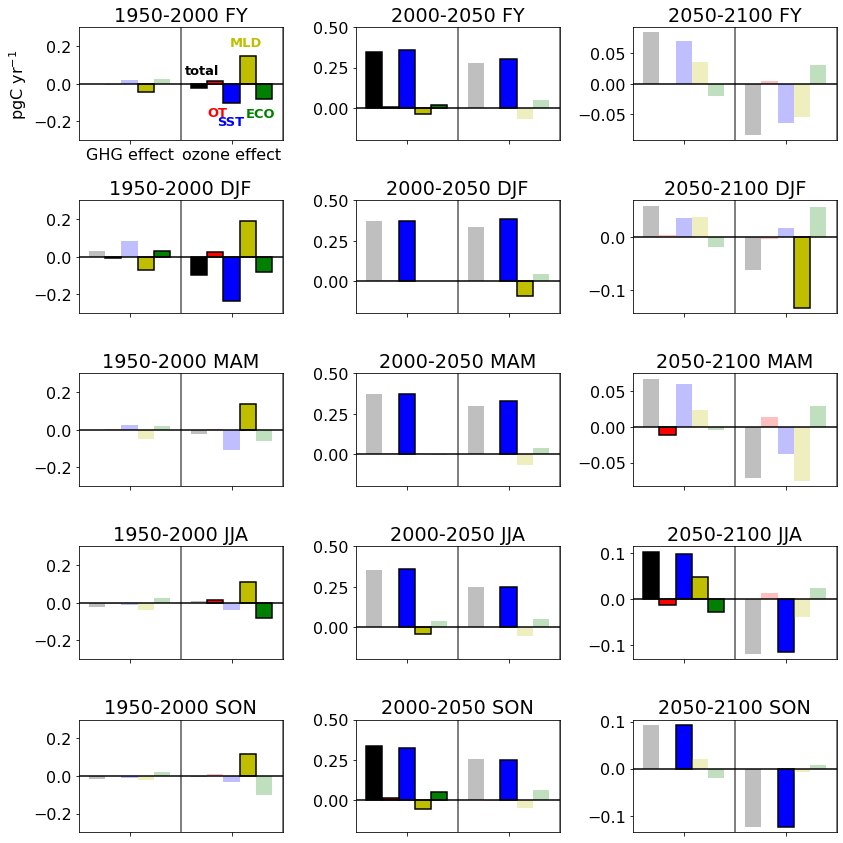

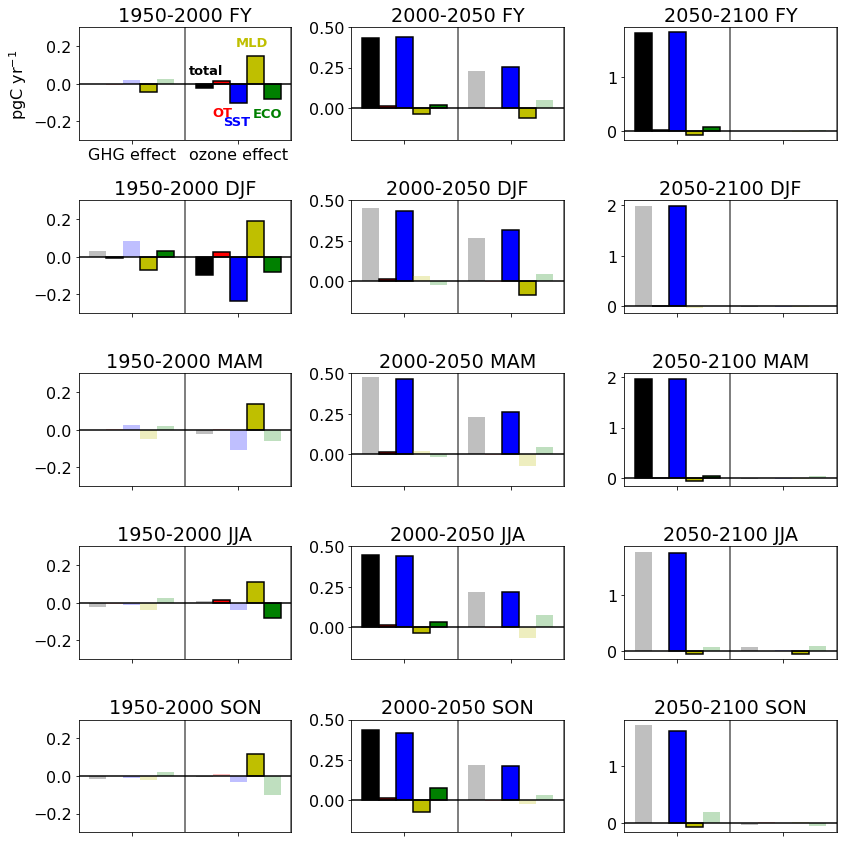

In [20]:
output_str = './data/BOE-OUTPUT-medusamodel3.nc'
valuedesc = 'biology, iron and kg parameterized, carbon data from MEDUSA'

tssp = 'ssp1'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-medusamodel-slide3.jpg'
make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc)

tssp = 'ssp3'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-medusamodel-slide3.jpg'
make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc)

# fnam_str = f'./figs/BOE-FIG-bothssp-medusamodel.jpg'
# make_boe_summary_graph_both_ssps(output_str, fnam_str, valuedesc)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


saved figure at ./figs/BOE-FIG-ssp1-bio-MEDUSA-fer-MEDUSA-cchem-MEDUSA.jpg
saved figure at ./figs/BOE-FIG-ssp3-bio-MEDUSA-fer-MEDUSA-cchem-MEDUSA.jpg
saved figure at ./figs/BOE-FIG-ssp1-bio-MEDUSA-fer-GEOTRACES-cchem-MEDUSA.jpg
saved figure at ./figs/BOE-FIG-ssp3-bio-MEDUSA-fer-GEOTRACES-cchem-MEDUSA.jpg


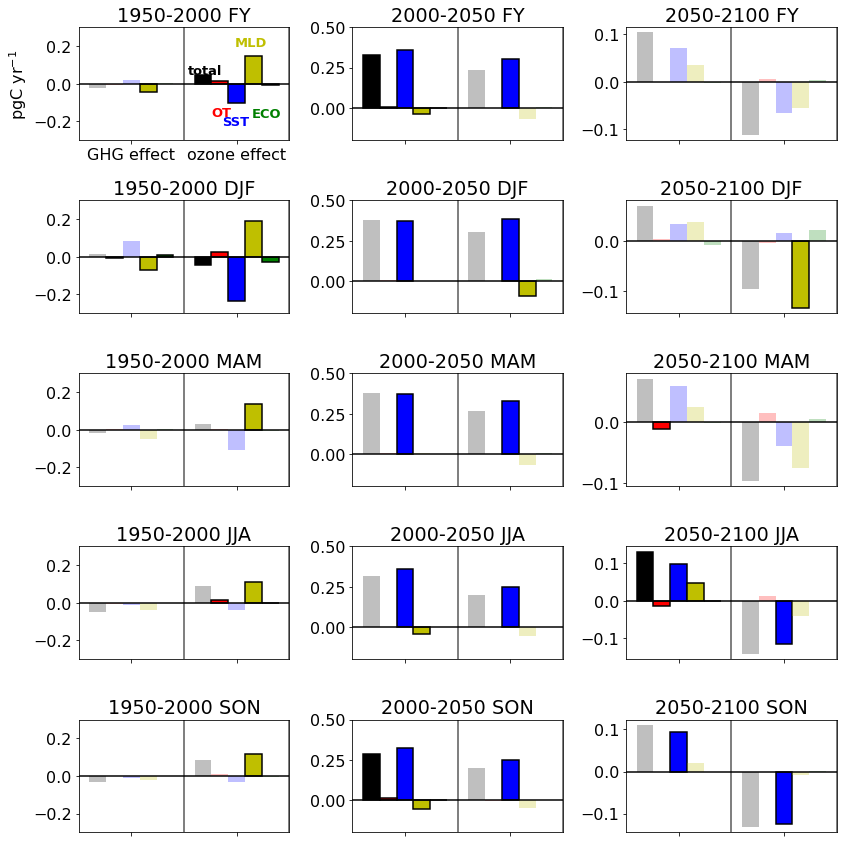

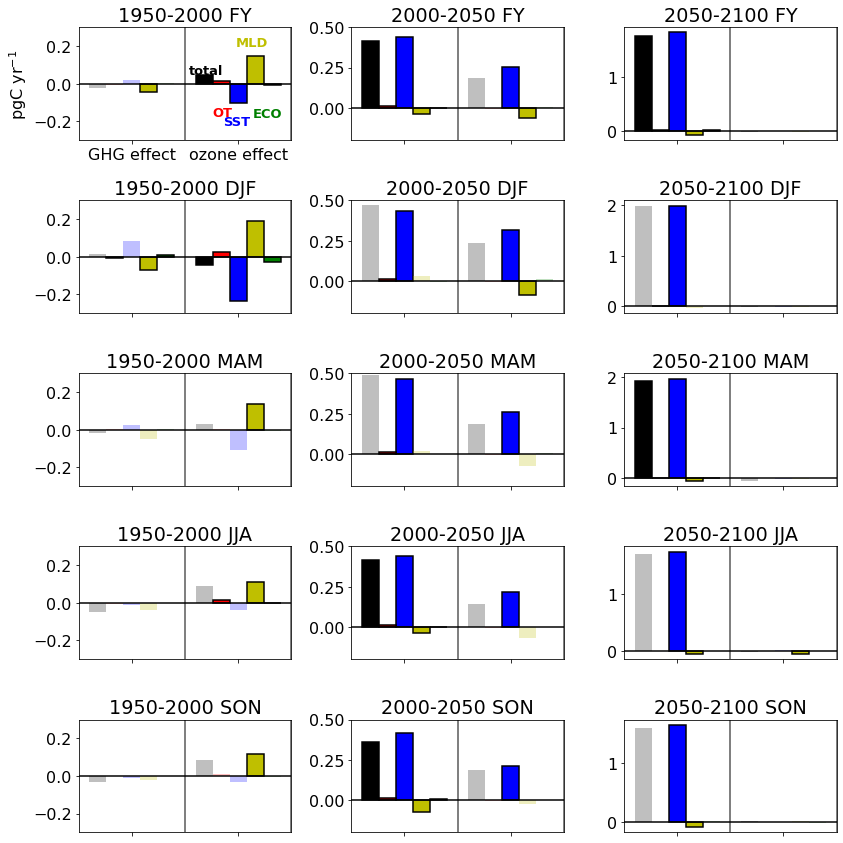

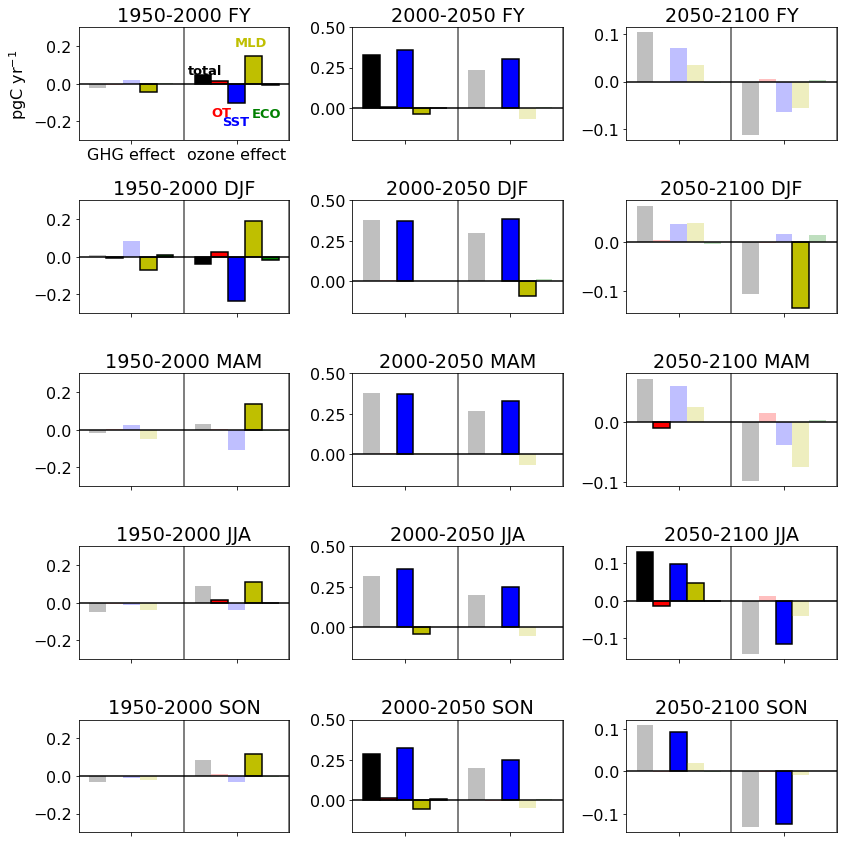

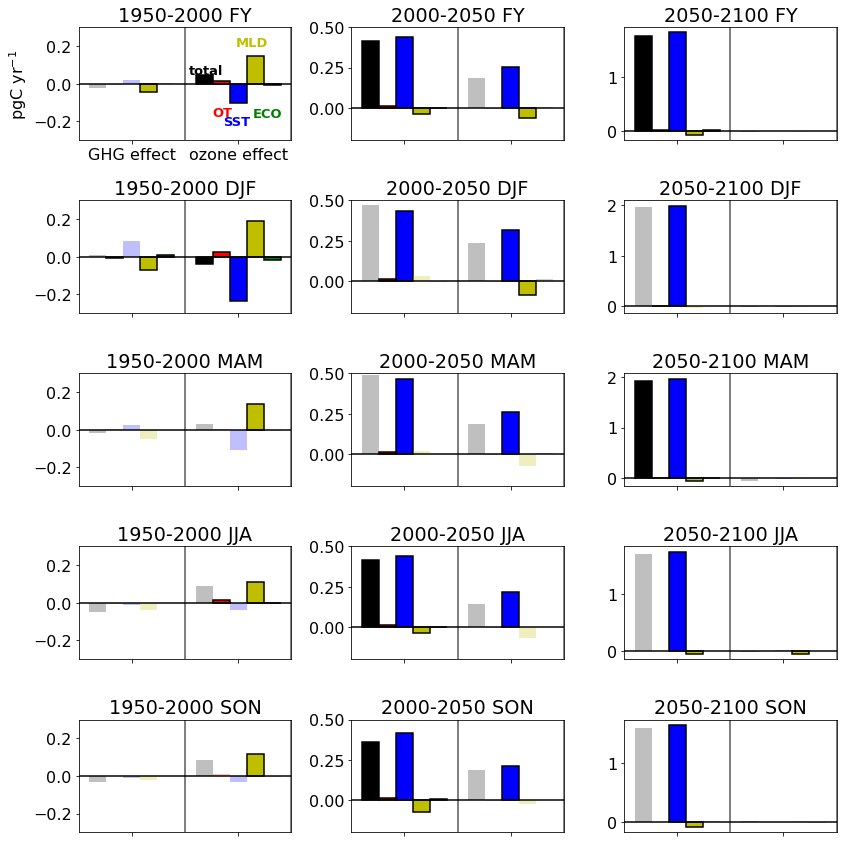

In [11]:
output_str = './data/BOE-OUTPUT-bio-MEDUSA-fer-MEDUSA-cchem-MEDUSA.nc'
valuedesc = 'biology, iron and kg parameterized, carbon data from MEDUSA'
tssp = 'ssp1'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-bio-MEDUSA-fer-MEDUSA-cchem-MEDUSA.jpg'
make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc)

tssp = 'ssp3'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-bio-MEDUSA-fer-MEDUSA-cchem-MEDUSA.jpg'
make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc)

####

output_str = './data/BOE-OUTPUT-bio-MEDUSA-fer-GEOTRACES-cchem-MEDUSA.nc'
valuedesc = 'biology, iron and kg parameterized, carbon data from MEDUSA'
tssp = 'ssp1'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-bio-MEDUSA-fer-GEOTRACES-cchem-MEDUSA.jpg'
make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc)

tssp = 'ssp3'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-bio-MEDUSA-fer-GEOTRACES-cchem-MEDUSA.jpg'
make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc)

# fnam_str = f'./figs/BOE-FIG-bothssp-medusamodel.jpg'
# make_boe_summary_graph_both_ssps(output_str, fnam_str, valuedesc)

saved figure at ./figs/BOE-FIG-bothssp-medusamodel.jpg


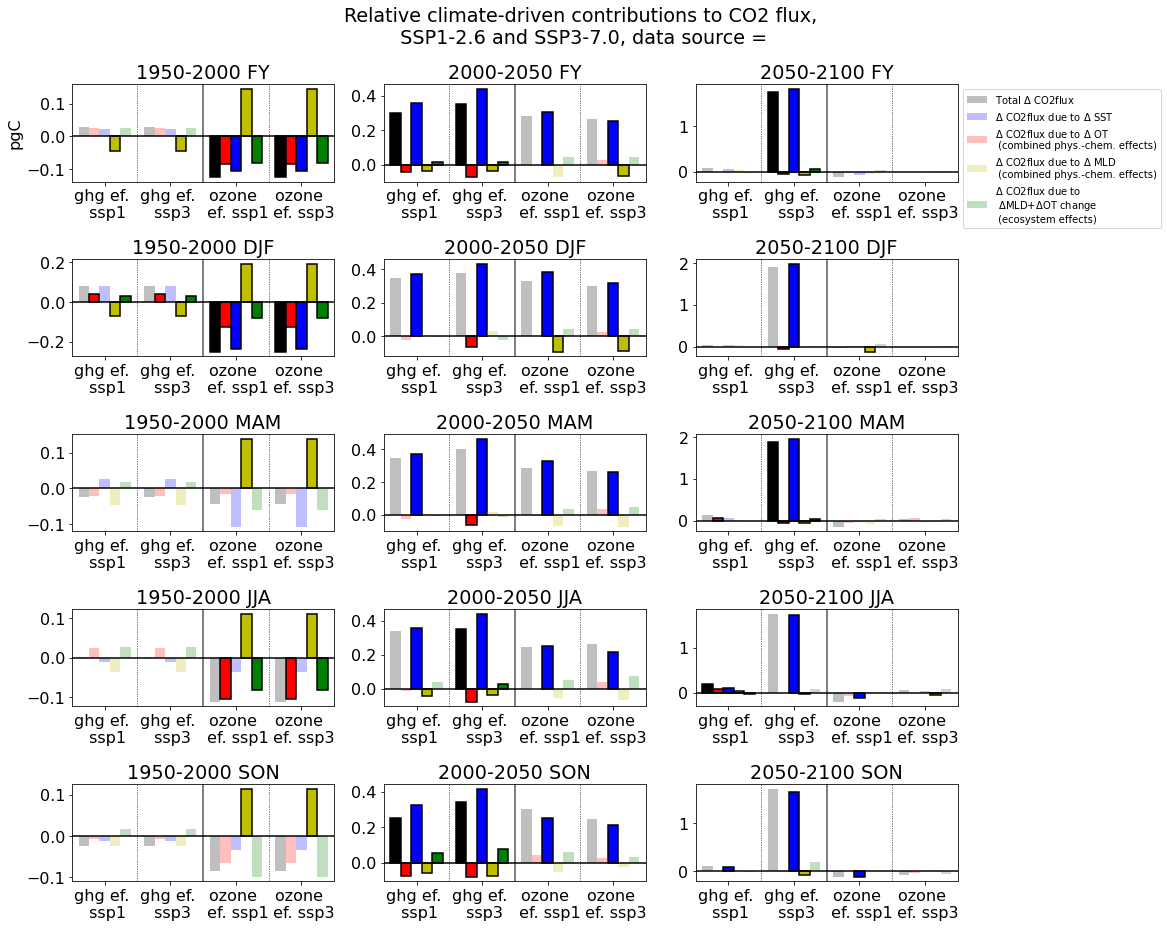

In [59]:
output_str = './data/BOE-OUTPUT-medusamodel.nc'
fnam_str = './figs/BOE-FIG-bothssp-medusamodel.jpg'
make_boe_summary_graph_both_ssps(output_str, fnam_str)

In [18]:
for i in range(0,15):
    t = 'z'
    if (i%3 == 0):
        t = 'a'
    if (i%3 == 1):
        t = 'b'
    if (i%3 == 2):
        t = 'c'     
    print(f'{i} {t}')

0 a
1 b
2 c
3 a
4 b
5 c
6 a
7 b
8 c
9 a
10 b
11 c
12 a
13 b
14 c
